### Connection

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from graphdatascience import GraphDataScience

URI = "neo4j://localhost:7687"
NAME_DB = "movies"

gds = GraphDataScience(URI, aura_ds=False, database=NAME_DB)

# Graph Analytics
In this section there will be two types of graph analysis:
- Similarity to create a recommendations systems
- Community detection

These two analysis will be done in a correlation way: results on similarity analysis will be use to do a better community detection.

## Similarity Analysis
Similarity analysis is done by considering the entire graph with all information added in preprocessing and exploratory analysis sections.  
![db_schema_after_exploratory.png](images/db_schema_after_exploratory.png)

As we can also see in the output of the second cell, the density of the graph is slightly increased with the added relations.  

Similarity analysis will be done in two way:
- Based on nodes relations
- Based on nodes properties  

So will be calculate similarity on Users and Movies nodes.  

In [8]:
result = gds.run_cypher(
    """
    CALL gds.graph.project(
    'movies-analyzed',
    {
        Movie:{properties:['popularity','favoriteMonth','year']},
        User:{properties: ['binaryGender','age','occupation', 'activity','favoriteMonth']},
        Genre:{}
    },
    {
        RATED: {properties: 'rating', orientation: 'UNDIRECTED'},
        BELONGS:{},
        LIKES:{properties: 'score', orientation: 'UNDIRECTED'}
    }
    )
    YIELD
    graphName AS graph, nodeProjection, nodeCount AS nodes, relationshipProjection, relationshipCount AS rels
"""
)
result

,graph,nodeProjection,nodes,relationshipProjection,rels
0,movies-analyzed,"{'User': {'label': 'User', 'properties': {'occ...",9764,"{'RATED': {'aggregation': 'DEFAULT', 'orientat...",2067010


In [9]:
gds.run_cypher(
    """
    CALL gds.graph.list('movies-analyzed')
    YIELD density,degreeDistribution;
"""
)

,density,degreeDistribution
0,0.021684,"{'min': 2, 'max': 3430, 'p90': 520, 'p999': 25..."


### Similarity based on relationships
In this similarity analysis will be used node the [Node Similarity](https://neo4j.com/docs/graph-data-science/current/algorithms/node-similarity/) algorithm in the Neo4j Graph Data Science library based on Jaccard similarity metrics.  


#### Users likes genres
This similarity analysis adds SIMILAR weighted relations between users with similar connections User-Genre.  
This analysis is most of time much higher because we don't have much heterogeneity between users connecting with genres.  
For this reason, relations were added from a similarity of 80%.  

In [11]:
result = gds.run_cypher(
    """
    CALL gds.nodeSimilarity.write('movies-analyzed',
    {
        nodeLabels:['User','Genre'],
        relationshipTypes:['LIKES'],
        relationshipWeightProperty: 'score', 
        similarityCutoff: 0.5,
        writeRelationshipType: 'SIMILAR',
        writeProperty: 'score'
    }) 
    """
)
print(f"Similarity relations created: {result.loc[0]['relationshipsWritten']}\n")
print(result.loc[0]["similarityDistribution"])

Similarity relations created: 60214

{'min': 0.5002517700195312, 'p5': 0.6168289184570312, 'max': 1.0000038146972656, 'p99': 0.9695663452148438, 'p1': 0.5818252563476562, 'p10': 0.6290168762207031, 'p90': 0.9301071166992188, 'p50': 0.6572227478027344, 'p25': 0.6437950134277344, 'p75': 0.8502273559570312, 'p95': 0.9483375549316406, 'mean': 0.7229983415013511, 'p100': 1.0000038146972656, 'stdDev': 0.12098913351048901}


#### Movies belongs genres
This similarity analysis adds SIMILAR weighted relations between movies with similar connections Movie-Genre.  
This analysis is most of time much higher because we don't have much diversification on the datasets.  
For this reason, relations were added from a similarity of 80%.  

In [33]:
result = gds.run_cypher(
    """
    CALL gds.nodeSimilarity.write('movies-analyzed',
    {
        nodeLabels:['Movie','Genre'],
        relationshipTypes:['BELONGS'], 
        similarityCutoff: 0.8,
        writeRelationshipType: 'SIMILAR',
        writeProperty: 'score'
    }) 
    """
)
print(f"Similarity relations created: {result.loc[0]['relationshipsWritten']}\n")
print(result.loc[0]["similarityDistribution"])

Similarity relations created: 33130

{'min': 0.7999992370605469, 'p5': 1.0000038146972656, 'max': 1.0000038146972656, 'p99': 1.0000038146972656, 'p1': 1.0000038146972656, 'p10': 1.0000038146972656, 'p90': 1.0000038146972656, 'p50': 1.0000038146972656, 'p25': 1.0000038146972656, 'p75': 1.0000038146972656, 'p95': 1.0000038146972656, 'mean': 0.999460488045068, 'p100': 1.0000038146972656, 'stdDev': 0.010410216796040048}


#### Users rate movies
This other similarity analysis adds SIMILAR_RATE weighted relations between users with similar connections User-Movie.  

This analysis is more precise and captures user behaviour within the network and finds more correct correlations.  
For this reason, relations were added from a similarity of 50%.  

In [35]:
result = gds.run_cypher(
    """
    CALL gds.nodeSimilarity.write('movies-analyzed',
    {
        nodeLabels:['User','Movie'],
        relationshipTypes:['RATED'], 
        similarityCutoff: 0.5,
        writeRelationshipType: 'SIMILAR_RATE',
        writeProperty: 'score',
        relationshipWeightProperty: 'rating'
    }) 
    """
)
print(f"Similarity relations created: {result.loc[0]['relationshipsWritten']}\n")
print(result.loc[0]["similarityDistribution"])

Similarity relations created: 524

{'min': 0.5, 'p5': 0.5, 'max': 1.0000038146972656, 'p99': 1.0000038146972656, 'p1': 0.5, 'p10': 0.5, 'p90': 1.0000038146972656, 'p50': 0.5999984741210938, 'p25': 0.5, 'p75': 1.0000038146972656, 'p95': 1.0000038146972656, 'mean': 0.7131035637309533, 'p100': 1.0000038146972656, 'stdDev': 0.2144020236922081}


#### Movies rated by users
This other similarity analysis adds SIMILAR_RATE weighted relations between movies with similar connections Movie-User.  

This analysis is more precise and captures  the popularity and appreciation of the movies within the network and finds more correct correlations.  
For this reason, relations were added from a similarity of 50%.  

In [34]:
result = gds.run_cypher(
    """
    CALL gds.nodeSimilarity.write('movies-analyzed',
    {
        nodeLabels:['Movie','User'],
        relationshipTypes:['RATED'], 
        relationshipWeightProperty: 'rating',
        similarityCutoff: 0.5,
        writeRelationshipType: 'SIMILAR_RATE',
        writeProperty: 'score'
    }) 
    """
)
print(f"Similarity relations created: {result.loc[0]['relationshipsWritten']}\n")
print(result.loc[0]["similarityDistribution"])

Similarity relations created: 524

{'min': 0.5, 'p5': 0.5, 'max': 1.0000038146972656, 'p99': 1.0000038146972656, 'p1': 0.5, 'p10': 0.5, 'p90': 1.0000038146972656, 'p50': 0.5999984741210938, 'p25': 0.5, 'p75': 1.0000038146972656, 'p95': 1.0000038146972656, 'mean': 0.7131035637309533, 'p100': 1.0000038146972656, 'stdDev': 0.2144020236922081}


### Similarity based on components
In this other similarity analysis will be used node the [K-Nearest Neighbors](https://neo4j.com/docs/graph-data-science/current/algorithms/knn/) algorithm in the Neo4j Graph Data Science library based on Jaccard similarity metrics.  

N.B.: concurrency:1 and randomSeed: 42 configurations are need to have same results on these tests

#### Users
This similarity analysis adds SIMILAR_KNN weighted relations between users with similar properties.  

For this reason, relations were added from a similarity of 70%.  

In [15]:
result = gds.run_cypher(
    """
    CALL gds.knn.write('movies-analyzed', {
        nodeLabels:['User'], 
        writeRelationshipType: 'SIMILAR_KNN',
        writeProperty: 'score',
        topK: 100, 
        concurrency: 1, 
        randomSeed: 42,
        similarityCutoff: 0.7,
        nodeProperties: ['binaryGender','age','occupation', 'activity','favoriteMonth']})
    """
)
print(f"Similarity relations created: {result.loc[0]['relationshipsWritten']}\n")
print(result.loc[0]["similarityDistribution"])

Similarity relations created: 547626

{'min': 0.6999969482421875, 'p5': 0.7095222473144531, 'max': 1.0000038146972656, 'p99': 1.0000038146972656, 'p1': 0.6999969482421875, 'p10': 0.7166633605957031, 'p90': 0.8666648864746094, 'p50': 0.7999992370605469, 'p25': 0.7333297729492188, 'p75': 0.8333320617675781, 'p95': 0.8999977111816406, 'mean': 0.7915988846093521, 'p100': 1.0000038146972656, 'stdDev': 0.06453635621702361}


#### Movies
This similarity analysis adds SIMILAR_KNN weighted relations between movies with similar properties.  

For this reason, relations were added from a similarity of 70%.  

In [41]:
result = gds.run_cypher(
    """
    CALL gds.knn.write('movies-analyzed', {
        nodeLabels:['Movie'],
        writeRelationshipType: 'SIMILAR_KNN',writeProperty: 'score',
        topK: 100,
        concurrency: 1,
        randomSeed: 42,
        similarityCutoff: 0.7,
        nodeProperties: ['popularity','favoriteMonth','year']})
    """
)
print(f"Similarity relations created: {result.loc[0]['relationshipsWritten']}\n")
print(result.loc[0]["similarityDistribution"])

Similarity relations created: 282993

{'min': 0.6999969482421875, 'p5': 0.7083320617675781, 'max': 1.0000038146972656, 'p99': 1.0000038146972656, 'p1': 0.6999969482421875, 'p10': 0.7222213745117188, 'p90': 1.0000038146972656, 'p50': 0.8333320617675781, 'p25': 0.75, 'p75': 0.8333320617675781, 'p95': 1.0000038146972656, 'mean': 0.8117299385465895, 'p100': 1.0000038146972656, 'stdDev': 0.0790926457674319}


## Recommendation Systems
After similarity analysis the graph become like this:  
![alt text](images/movies_with_similarity.svg)  
Having these information we can build a recommendation system mixed with relations similarity and components similarity.
  
Init our pseudo-random generator with fixed seed.

In [30]:
import random

random.seed(0)

### Movie based
We choose a random film from dataset

In [31]:
movieId = random.randint(0, 3952)

gds.run_cypher(
    f"""
    MATCH (m:Movie) WHERE m.movieId = {movieId}
    RETURN m.movieId as movieId,m.title as title
    """
).loc[0]["title"]

'Blood and Sand (Sangre y Arena) (1989)'

After that we pick 60 movies similar based our three similarity metrics (20 movies for each).  

We joins these three lists and calculate a mixed score metrics with different weights  
__general_score = scoreGenre * .2 + scoreRate * .5 + scoreKnn * .3__  

Sorts list by `general_score` and filter first 10


In [77]:
# I take the top 20 most similar films according to previously created similarity edges for each similarity type
list_with_similar_genre = gds.run_cypher(
    f"""
    MATCH (m:Movie WHERE m.movieId = {movieId})-[s:SIMILAR]-(m2:Movie)
    RETURN DISTINCT m2.movieId as movieId, s.score as scoreGenre
    ORDER BY scoreGenre DESC
    limit 20
    """
)
list_with_similar_rate = gds.run_cypher(
    f"""
    MATCH (m:Movie WHERE m.movieId = {movieId})-[s:SIMILAR_RATE]-(m2:Movie)
    RETURN DISTINCT m2.movieId as movieId, s.score as scoreRate
    ORDER BY scoreRate DESC
    limit 20
    """
)
list_with_similar_knn = gds.run_cypher(
    f"""
    MATCH (m:Movie WHERE m.movieId = {movieId})-[s:SIMILAR_KNN]-(m2:Movie)
    RETURN DISTINCT m2.movieId as movieId, s.score as scoreKnn
    ORDER BY scoreKnn DESC
    limit 20
    """
)

# I merge the lists
list = pd.merge(
    list_with_similar_genre, list_with_similar_rate, how="outer", on="movieId"
)
list = list.merge(list_with_similar_knn, how="outer", on="movieId")

# I fill in the missing values with 0
list.fillna(0, inplace=True)

# I calculate the general score
list["general_score"] = (
    list["scoreGenre"] * 0.2 + list["scoreRate"] * 0.5 + list["scoreKnn"] * 0.3
)

# I sort the list by general score and take the top 10
list.sort_values(by="general_score", ascending=False, inplace=True)
list.reset_index(drop=True, inplace=True)

# I pick the top 10 movies
list = list.head(10)

list

[3123, 3166, 706, 2039, 142, 3687, 1989, 868, 1107, 2742]

With a simple query we can have our 10 recommended movies

In [79]:
gds.run_cypher(
    f"""
    MATCH (m:Movie) WHERE m.movieId IN {list['movieId'].tolist()}
    RETURN m.movieId as movieId,m.title as title
    """
)

,movieId,title
0,142,Shadows (Cienie) (1988)
1,706,Sunset Park (1996)
2,868,Death in Brunswick (1991)
3,1107,Loser (1991)
4,1989,Prom Night III: The Last Kiss (1989)
5,2039,Cheetah (1989)
6,2742,M�nage (Tenue de soir�e) (1986)
7,3123,Spring Fever USA (a.k.a. Lauderdale) (1989)
8,3166,Brenda Starr (1989)
9,3687,Light Years (1988)


### User based
We choose a random user

In [80]:
userId = random.randint(1, 6040)

gds.run_cypher(
    f"""
    MATCH (u:User {{userId: {userId}}})
    RETURN u.gender as gender, u.age as age, u.occupation as occupation, u.activity as activity, u.favoriteMonth as favoriteMonth
    """
)

,gender,age,occupation,activity,favoriteMonth
0,M,25,20,9,6


After that we pick the top 30 user similar based our three similarity metrics (10 user for each).  

We joins these three lists and calculate a mixed score metrics with different weights  
__general_score = scoreGenre * .2 + scoreRate * .5 + scoreKnn * .3__  

Sorts list by `general_score` and filter first 10

In [106]:
# I take the top 10 most similar users according to previously created similarity edges for each similarity type
list_with_similar_genre = gds.run_cypher(
    f"""
    MATCH (u:User WHERE u.userId = {userId})-[s:SIMILAR]-(u2:User)
    RETURN DISTINCT u2.userId as userId, s.score as scoreGenre
    ORDER BY scoreGenre DESC
    limit 10
    """
)
list_with_similar_rate = gds.run_cypher(
    f"""
    MATCH (u:User WHERE u.userId = {userId})-[s:SIMILAR_RATE]-(u2:User)
    RETURN DISTINCT u2.userId as userId, s.score as scoreRate
    ORDER BY scoreRate DESC
    limit 10
    """
)
list_with_similar_knn = gds.run_cypher(
    f"""
    MATCH (u:User WHERE u.userId = {userId})-[s:SIMILAR_KNN]-(u2:User)
    RETURN DISTINCT u2.userId as userId, s.score as scoreKnn
    ORDER BY scoreKnn DESC
    limit 10
    """
)

# I merge the lists
list = pd.merge(
    list_with_similar_genre, list_with_similar_rate, how="outer", on="userId"
)
list = list.merge(list_with_similar_knn, how="outer", on="userId")

# I fill in the missing values with 0
list.fillna(0, inplace=True)

# I calculate the general score
list["general_score"] = (
    list["scoreGenre"] * 0.2 + list["scoreRate"] * 0.5 + list["scoreKnn"] * 0.3
)

# I sort the list by general score
list.sort_values(by="general_score", ascending=False, inplace=True)
list.reset_index(drop=True, inplace=True)

# I pick the top 10 users
list = list.head(10)

list

/tmp/ipykernel_1424/494110991.py:30: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  list.fillna(0,inplace=True)


,userId,scoreGenre,scoreRate,scoreKnn,score
0,5722,0.0,0,0.900000,0.270
1,5277,0.0,0,0.900000,0.270
2,5323,0.0,0,0.900000,0.270
3,3910,0.0,0,0.866667,0.260
4,5376,0.0,0,0.850000,0.255
5,5148,0.0,0,0.850000,0.255
6,5408,0.0,0,0.850000,0.255
7,3158,0.0,0,0.833333,0.250
8,5488,0.0,0,0.833333,0.250
9,5252,0.0,0,0.833333,0.250


Having the 10 most similar people, for each one I select the 3 most liked films that have not yet been seen by the person taken as an example. 

I group the results and if I find films recommended by several people I add up their general_score.

Finally I select the top 10

In [152]:
# I take the top 3 favorite movies of the top 10 similar users
movies_list = pd.DataFrame()
for _, similar_user in list.iterrows():
    favorite_movies = gds.run_cypher(
        f"""
        MATCH (uSample:User{{userId: {userId}}})
        MATCH (u:User {{userId: {similar_user['userId']}}})-[r:RATED]->(m:Movie)
        WHERE NOT (uSample)-[:RATED]->(m)
        RETURN m.movieId as movieId, r.rating as rating
        ORDER BY rating DESC
        LIMIT 3
        """
    )
    favorite_movies["general_score"] = similar_user["general_score"]
    movies_list = pd.concat([movies_list, favorite_movies])

# I group the results and if I find the movies recommended by more people I sum their general_score.
movies_list = movies_list.groupby(by="movieId").agg(
    {"general_score": "sum", "rating": "size"}
)
movies_list.columns = ["general_score", "times"]

# I sort the list by general score and take the top 10
movies_list.sort_values(by="general_score", ascending=False, inplace=True)
movies_list = movies_list.head(10)

movies_list

,score,times
movieId,,
2028,0.785,3
527,0.775,3
1089,0.510,2
1066,0.270,1
1084,0.270,1
2010,0.270,1
2712,0.270,1
1082,0.270,1
1073,0.270,1


With a simple query we can have our 10 recommended movies

In [153]:
gds.run_cypher(
    f"""
    MATCH (m:Movie) WHERE m.movieId IN {movies_list.index.to_list()}
    RETURN m.movieId as movieId,m.title as title
    """
)

,movieId,title
0,527,Schindler's List (1993)
1,1066,Shall We Dance? (1937)
2,1073,Willy Wonka and the Chocolate Factory (1971)
3,1082,Candidate The (1972)
4,1084,Bonnie and Clyde (1967)
5,1089,Reservoir Dogs (1992)
6,2010,Metropolis (1926)
7,2028,Saving Private Ryan (1998)
8,2712,Eyes Wide Shut (1999)
9,3319,Judy Berlin (1999)


## Community detection
Thanks to similarity analysis we have a subgraph on which we can do community detection.  
This is the structure of `users-similarities`  
![alt text](images/users_similarities.svg)  

This one is a little part of the graph with 300 Users nodes  
![alt text](images/users_similarities_300_nodes.svg)
 

In [172]:
## RESCALE SIMILARITY SCORES
gds.run_cypher(
    f"""
    MATCH (:User)-[s:SIMILAR]-(:User)
    SET s.score= s.score * 0.2
    """
)
gds.run_cypher(
    f"""
    MATCH (:User)-[s:SIMILAR_KNN]-(:User)
    SET s.score= s.score * 0.4
    """
)
gds.run_cypher(
    f"""
    MATCH (:User)-[s:SIMILAR_RATE]-(:User)
    SET s.score= s.score * 0.4
    """
)

""


In [155]:
result = gds.run_cypher(
    """
    CALL gds.graph.project(
    'users-similarities',
    'User',
    {
        SIMILAR_KNN: {properties: 'score', orientation: 'UNDIRECTED'},
        SIMILAR: {properties: 'score', orientation: 'UNDIRECTED'},
        SIMILAR_RATE: {properties: 'score', orientation: 'UNDIRECTED'}
    }
    )
    YIELD
    graphName AS graph, nodeProjection, nodeCount AS nodes, relationshipProjection, relationshipCount AS rels
"""
)
result

,graph,nodeProjection,nodes,relationshipProjection,rels
0,users-similarities,"{'User': {'label': 'User', 'properties': {}}}",6040,"{'SIMILAR_RATE': {'aggregation': 'DEFAULT', 'o...",1252676


In [156]:
gds.run_cypher(
    """
    CALL gds.graph.list('users-similarities')
    YIELD density,degreeDistribution;
"""
)

,density,degreeDistribution
0,0.034343,"{'min': 16, 'max': 372, 'p90': 278, 'p999': 34..."


### Check some stats from Neo4j algorithms

#### Strongly Connected Components
The network is an entire strongly connected component

In [162]:
gds.run_cypher(
    """
    CALL gds.scc.stats('users-similarities')
    YIELD componentCount, componentDistribution
    """
)

,componentCount,componentDistribution
0,1,"{'min': 6040, 'p5': 6040, 'max': 6040, 'p999':..."


#### Louvain stats
The [louvain](https://neo4j.com/docs/graph-data-science/current/algorithms/louvain/) stats find 7 community with an acceptable modularity.  

I did various tests to improve this result but the effects were mediocre, so for now I accepted this result and went on with the analysis

In [173]:
gds.run_cypher(
    """
    CALL gds.louvain.stats('users-similarities', 
    { 
        relationshipWeightProperty: 'score'
    })
    YIELD communityCount, modularity, modularities
"""
)

,communityCount,modularity,modularities
0,8,0.603948,"[0.49057514577541633, 0.5885440793248924, 0.60..."


### Define communities

In [174]:
gds.run_cypher(
    """
    CALL gds.louvain.write('users-similarities', 
    { 
        writeProperty:'communityId',
        relationshipWeightProperty: 'score'
    })
    YIELD communityCount, modularity, modularities
"""
)

,communityCount,modularity,modularities
0,8,0.608552,"[0.5207403932306213, 0.5993517257350112, 0.608..."


In [175]:
result = gds.run_cypher(
    """
    MATCH (u:User)
    RETURN u.communityId as communityId, COUNT(*) as numNodes
    ORDER BY numNodes DESC
    
    """
)
communityId1 = result.iloc[0]["communityId"]
communityId2 = result.iloc[1]["communityId"]
result

,communityId,numNodes
0,2903,1262
1,4112,1195
2,351,1103
3,6029,835
4,5059,550
5,614,496
6,1978,380
7,2656,219


### We will pick the two biggest community

In [176]:
from helpers import AGE_LABELS, OCCUPATION_LABELS


community1 = gds.run_cypher(
    f"""
    MATCH (u:User WHERE u.communityId={communityId1})
    RETURN u.age AS age, u.occupation AS occupation, u.gender AS gender, u.favoriteMonth AS favoriteMonth, u.activity AS activity
    """
)
community1_age = community1["age"].value_counts().rename(index=AGE_LABELS).sort_index()
community1_occupation = (
    community1["occupation"]
    .value_counts()
    .rename(index=OCCUPATION_LABELS)
    .sort_values()
)


community2 = gds.run_cypher(
    f"""
    MATCH (u:User WHERE u.communityId={communityId2})
    RETURN u.age AS age, u.occupation AS occupation, u.gender AS gender, u.favoriteMonth AS favoriteMonth, u.activity AS activity
    """
)
community2_age = community2["age"].value_counts().rename(index=AGE_LABELS).sort_index()
community2_occupation = (
    community2["occupation"]
    .value_counts()
    .rename(index=OCCUPATION_LABELS)
    .sort_values()
)

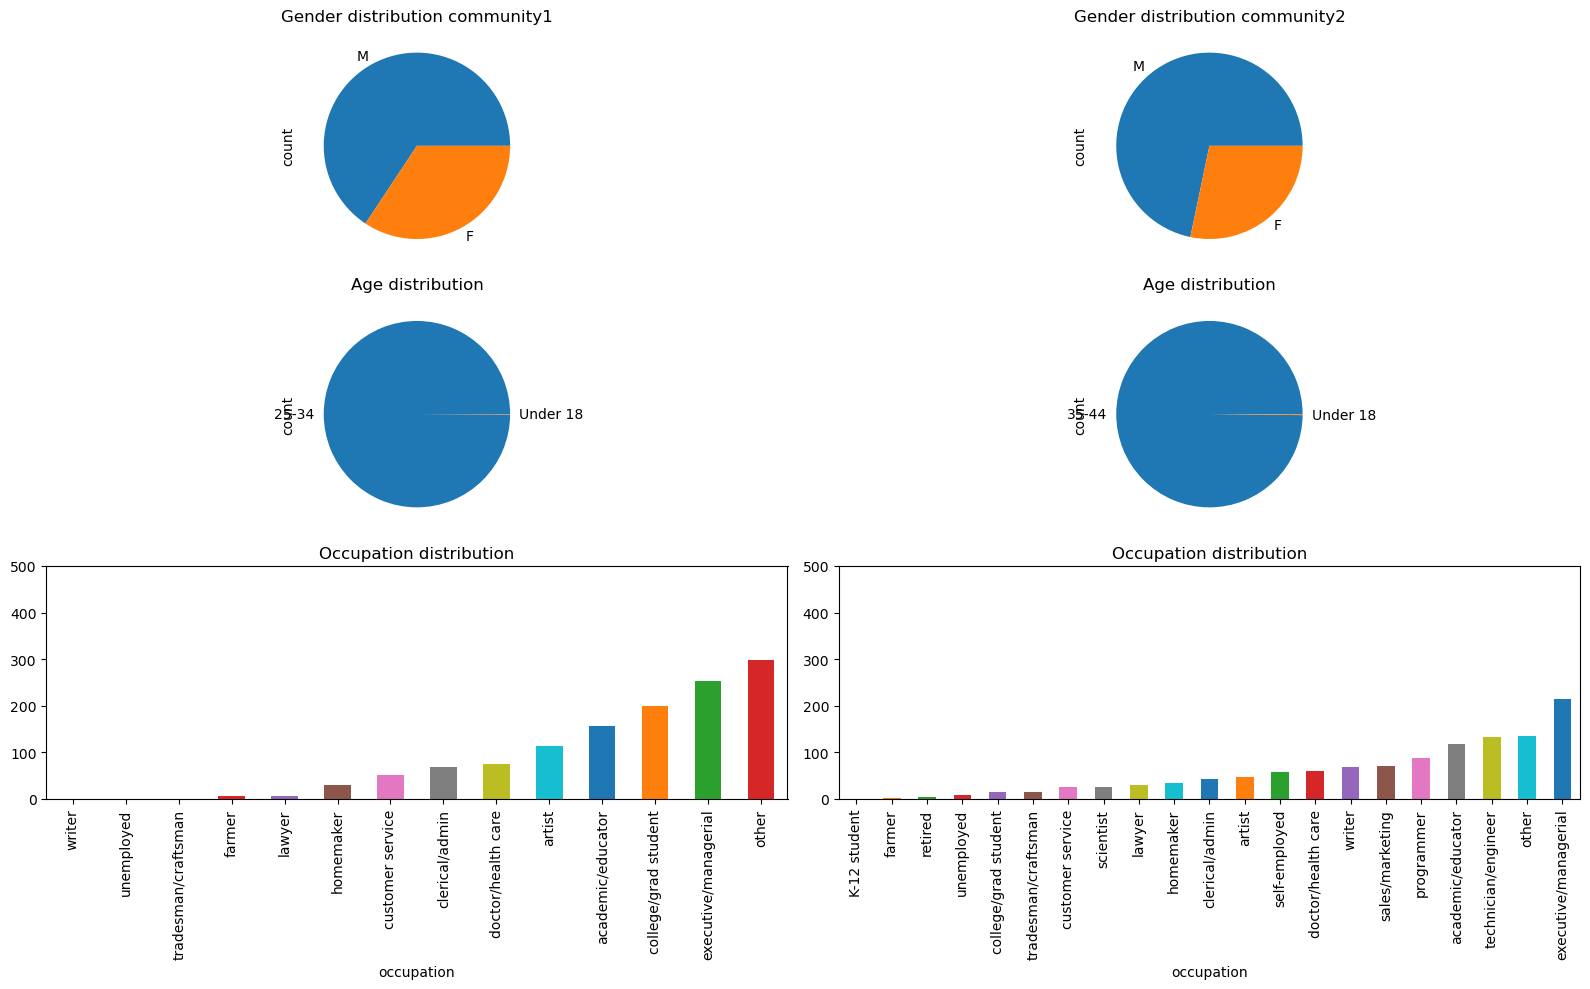

In [177]:
from matplotlib.colors import TABLEAU_COLORS

fig, ax = plt.subplots(3, 2, figsize=(16, 10))

community1["gender"].value_counts().plot(
    kind="pie", title="Gender distribution community1", ax=ax[0, 0]
)
community2["gender"].value_counts().plot(
    kind="pie", title="Gender distribution community2", ax=ax[0, 1]
)
community1_age.plot(
    kind="pie",
    title="Age distribution",
    color=TABLEAU_COLORS,
    ax=ax[1, 0],
)
community2_age.plot(
    kind="pie",
    title="Age distribution",
    color=TABLEAU_COLORS,
    ax=ax[1, 1],
)
community1_occupation.plot(
    kind="bar",
    title="Occupation distribution",
    color=TABLEAU_COLORS,
    ylim=(0, 500),
    ax=ax[2, 0],
)
community2_occupation.plot(
    kind="bar",
    title="Occupation distribution",
    color=TABLEAU_COLORS,
    ylim=(0, 500),
    ax=ax[2, 1],
)
fig.tight_layout()

In [276]:
community1_occupation.rename("community1")
community2_occupation.rename("community2")

occupation
K-12 student              1
farmer                    3
retired                   5
unemployed                9
college/grad student     14
tradesman/craftsman      16
customer service         25
scientist                25
lawyer                   31
homemaker                35
clerical/admin           42
artist                   47
self-employed            58
doctor/health care       59
writer                   68
sales/marketing          70
programmer               86
academic/educator       118
technician/engineer     132
other                   135
executive/managerial    214
Name: community2, dtype: int64

<Axes: title={'center': 'Favorite Month'}, xlabel='favoriteMonth'>

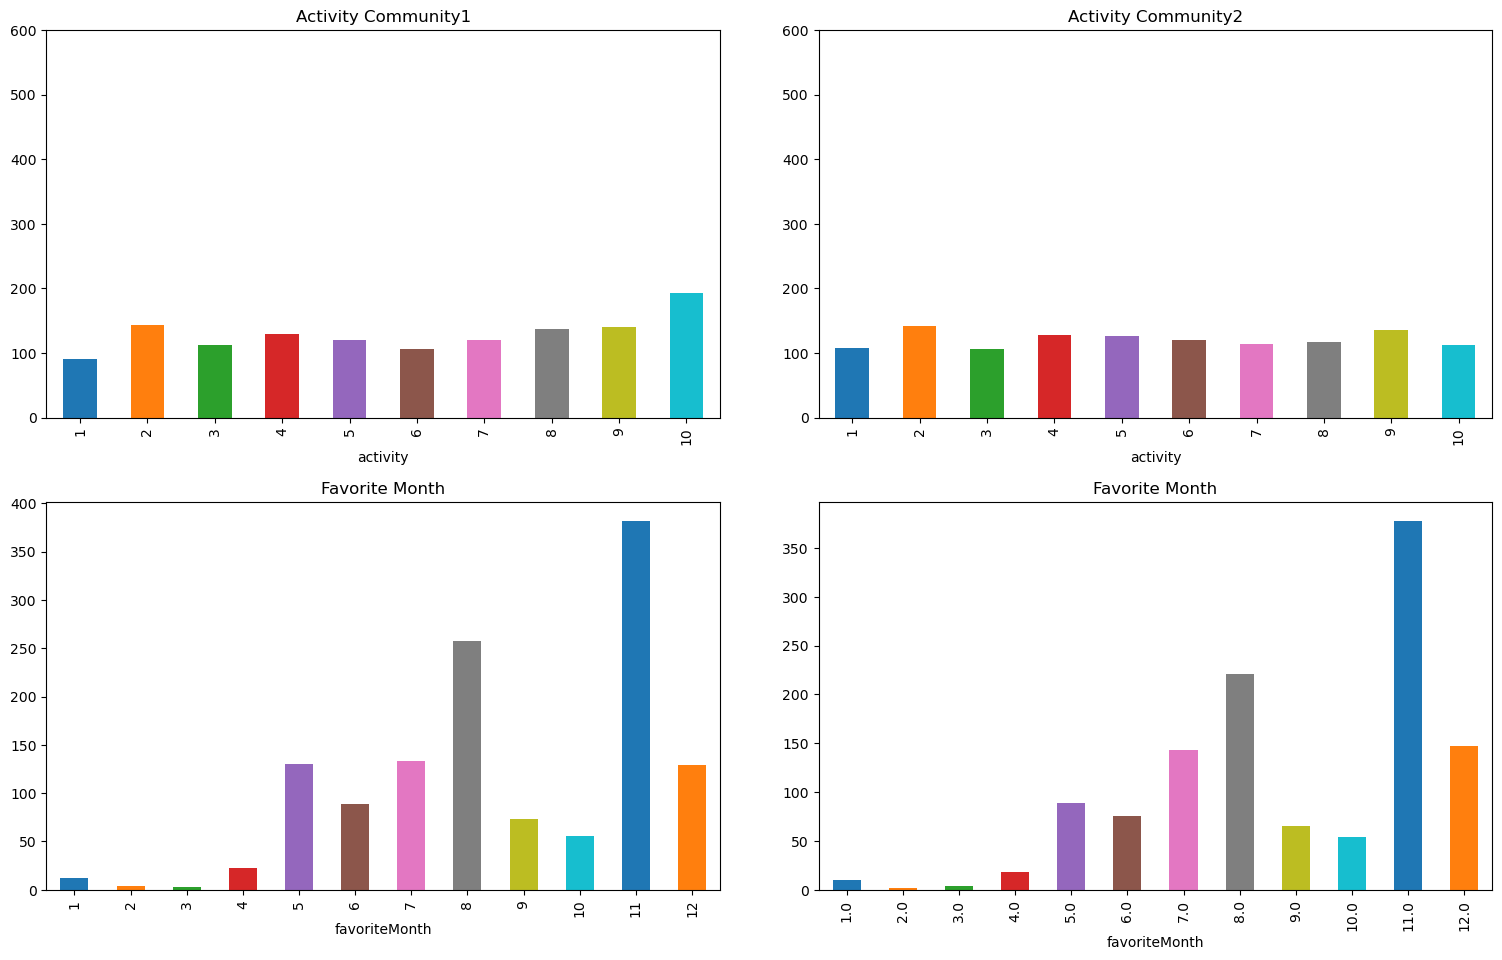

In [23]:
fig, ax = plt.subplots(2, 2, figsize=(16, 10))
fig.tight_layout(pad=4)
community1["activity"].value_counts().sort_index().plot(
    kind="bar",
    title="Activity Community1",
    color=TABLEAU_COLORS,
    ylim=(0, 600),
    ax=ax[0, 0],
)
community2["activity"].value_counts().sort_index().plot(
    kind="bar",
    title="Activity Community2",
    color=TABLEAU_COLORS,
    ylim=(0, 600),
    ax=ax[0, 1],
)

community1["favoriteMonth"].value_counts().sort_index().plot(
    kind="bar", title="Favorite Month", color=TABLEAU_COLORS, ax=ax[1, 0]
)
community2["favoriteMonth"].value_counts().sort_index().plot(
    kind="bar", title="Favorite Month", color=TABLEAU_COLORS, ax=ax[1, 1]
)

In [178]:
gds.run_cypher(
    f"""
    MATCH (u:User WHERE u.communityId={communityId1})-[r:RATED WHERE r.rating>3]->(m:Movie)
    WITH m, COUNT(r) AS numPositiveRatings
    RETURN m.title AS title, numPositiveRatings
    ORDER BY numPositiveRatings DESC, title  DESC
    LIMIT 10
"""
)

,title,numPositiveRatings
0,American Beauty (1999),681
1,Star Wars: Episode V - The Empire Strikes Back...,594
2,Star Wars: Episode IV - A New Hope (1977),594
3,Silence of the Lambs The (1991),579
4,Raiders of the Lost Ark (1981),543
5,Matrix The (1999),520
6,Star Wars: Episode VI - Return of the Jedi (1983),512
7,Sixth Sense The (1999),511
8,Shawshank Redemption The (1994),511
9,Saving Private Ryan (1998),500


In [179]:
gds.run_cypher(
    f"""
    MATCH (u:User WHERE u.communityId={communityId2})-[r:RATED WHERE r.rating>3]->(m:Movie)
    WITH m, COUNT(r) AS numPositiveRatings
    RETURN m.title AS title, numPositiveRatings
    ORDER BY numPositiveRatings DESC, title  DESC
    LIMIT 10
"""
)

,title,numPositiveRatings
0,Star Wars: Episode IV - A New Hope (1977),536
1,Star Wars: Episode V - The Empire Strikes Back...,487
2,American Beauty (1999),486
3,Raiders of the Lost Ark (1981),458
4,Saving Private Ryan (1998),436
5,Silence of the Lambs The (1991),433
6,Terminator 2: Judgment Day (1991),428
7,Godfather The (1972),421
8,Sixth Sense The (1999),420
9,Fargo (1996),404


In [180]:
community1_movies = gds.run_cypher(
    f"""
    MATCH (u:User WHERE u.communityId={communityId1})-[r:RATED WHERE r.rating>3]->(m:Movie)
    WITH m, AVG(r.rating) AS avgRating
    RETURN m.movieId AS movieId, avgRating
    """
)

community2_movies = gds.run_cypher(
    f"""
    MATCH (u:User WHERE u.communityId={communityId2})-[r:RATED WHERE r.rating>3]->(m:Movie)
    WITH m, AVG(r.rating) AS avgRating
    RETURN m.movieId AS movieId, avgRating
    """
)

In [181]:
movies = community1_movies.merge(
    community2_movies,
    on="movieId",
    how="outer",
    suffixes=("_community1", "_community2"),
)

In [182]:
movies = (
    movies[
        (movies["avgRating_community1"].isnull())
        | (movies["avgRating_community2"].isnull())
    ]
    .sort_values(by=["avgRating_community1", "avgRating_community2"], ascending=False)
    .reset_index(drop=True)
)

In [183]:
movies

,movieId,avgRating_community1,avgRating_community2
0,59,5.0,NaN
1,250,5.0,NaN
2,393,5.0,NaN
3,411,5.0,NaN
4,557,5.0,NaN
...,...,...,...
394,3878,NaN,4.0
395,3886,NaN,4.0
396,3906,NaN,4.0
397,3912,NaN,4.0


<Axes: title={'center': 'Average rating per movie'}>

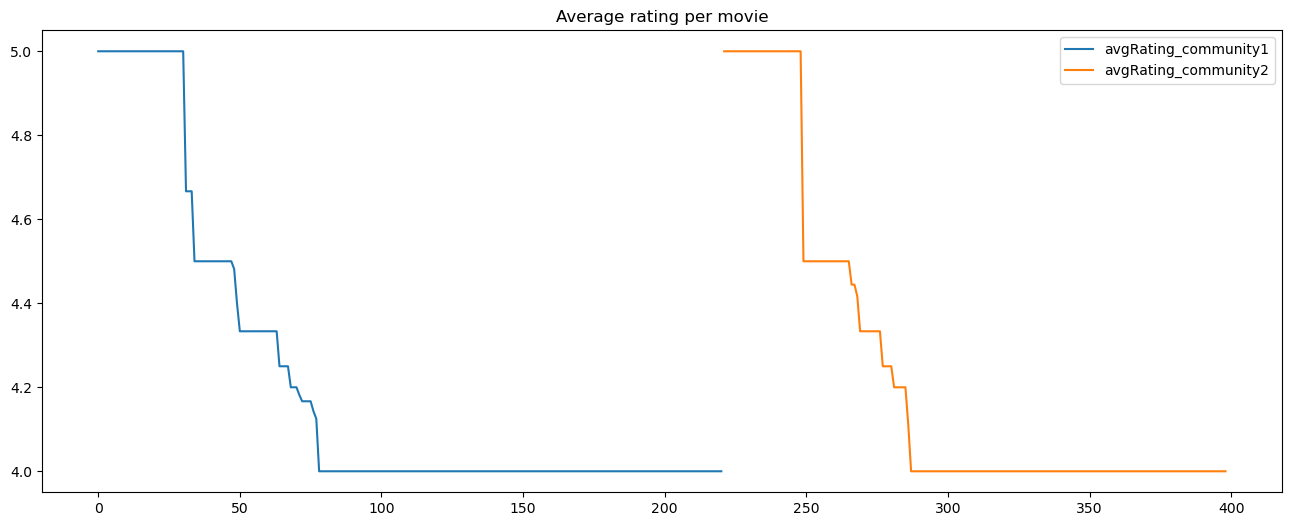

In [184]:
movies.plot(
    kind="line",
    y=["avgRating_community1", "avgRating_community2"],
    title="Average rating per movie",
    figsize=(16, 6),
)

In [279]:
# Sistemare i grafici per vedere meglio le differenze
# aggiungere descrizione partendo da expoloratory sezione add property
## NON FARE ALTRO